In [1]:
#|default_exp activations

# Activations stats

In [2]:
#|export
from __future__ import annotations
import math
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import * 

In [3]:
import torch.nn.functional as F
from pathlib import Path
from operator import attrgetter, itemgetter

from torch import tensor, nn, optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close
from IPython.core.debugger import set_trace

In [4]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
import logging; logging.disable(logging.WARNING)

In [5]:
#|export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [6]:
x,y = 'image', 'label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

  0%|          | 0/2 [00:00<?, ?it/s]

## Baseline

In [7]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1, 8),   # 14x14
        conv(8, 16),  # 7x7
        conv(16, 32), # 4x4
        conv(32, 64), # 2x2
        conv(64, 10, act=False), #1x1
        nn.Flatten()]

In [8]:
from torcheval.metrics import MulticlassAccuracy

In [9]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

In [10]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.161,2.272,0,train
0.308,1.760,0,eval


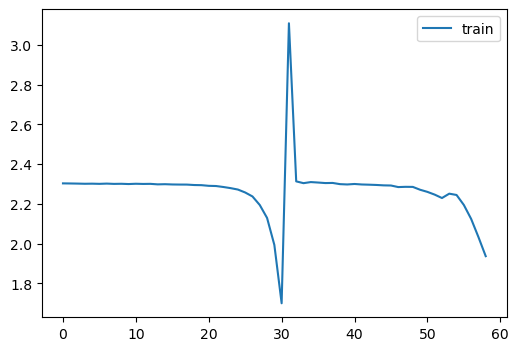

In [11]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

## Hooks

### Manual insertion

In [12]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds[i].append(to_cpu(x).std())
        return x

    def __iter__(self): return iter(self.layers)

accuracy,loss,epoch,train
0.161,2.272,0,train
0.308,1.760,0,eval


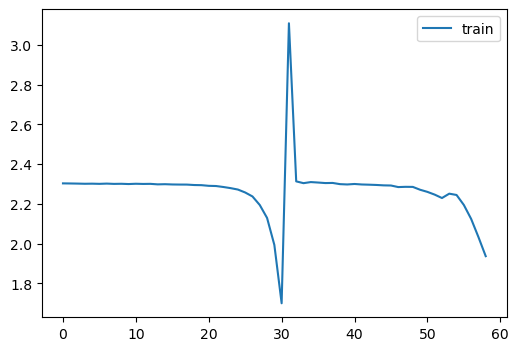

In [13]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

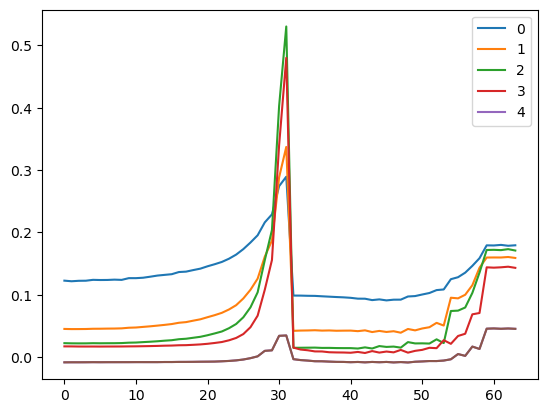

In [14]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5))

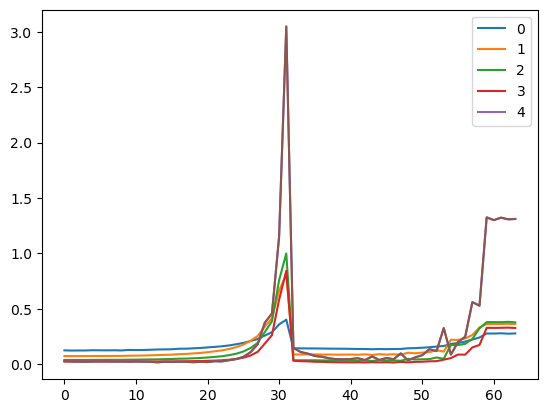

In [15]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5))

### Hooks

In [16]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [17]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [18]:
def append_stats(i, model, inp, out):
    act_means[i].append(to_cpu(out).mean())
    act_stds[i].append(to_cpu(out).std())

In [19]:
for i, m in enumerate(model):
    m.register_forward_hook(partial(append_stats, i))

In [20]:
fit(model)


KeyboardInterrupt



In [ ]:
for o in act_means: plt.plot(o)
plt.legend(range(5))

In [ ]:
for o in act_stds: plt.plot(o)
plt.legend(range(5))

In [ ]:
#|export
class Hook:
    def __init__(self, m): self.hook = m.register_forward_hook(self)
    def __call__(self, mod, inp, out): pass
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [ ]:
#|export
def hook(func):
    class HookFunc(Hook):
        def __call__(self, mod, inp, out):
            return func(self, mod, inp, out)
    return HookFunc

In [ ]:
class StatsHook(Hook):
    def __init__(self, m):
        super().__init__(m)
        self.stats = ([], [])
        
    def __call__(self, mod, inp, out): 
        acts = to_cpu(out)
        self.stats[0].append(acts.mean())
        self.stats[1].append(acts.std())

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [ ]:
hooks = [StatsHook(l) for l in model[:5].children()]

In [ ]:
learn = fit(model)

In [ ]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));

In [ ]:
@hook
def stats_hook(hook, m, inp, out):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    acts = to_cpu(out)
    self.stats[0].append(acts.mean())
    self.stats[1].append(acts.std())    

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [ ]:
hooks = [StatsHook(l) for l in model[:5].children()]

In [ ]:
learn = fit(model)

In [ ]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));

In [ ]:
a = {'hello': 'world', 'hey': 'you'}

In [ ]:
test(list(range(3)), hello="world")

In [40]:
#|export
from IPython.core.debugger import set_trace

def _model_iter(ms):
    if len(ms) == 0:
        return 
    m, *rest = ms    
    children = list(m.children())
    if len(children) == 0:
        yield m
        
    rest = children + rest
    yield from _model_iter(rest)

def model_iter(m):
    return _model_iter([m])

In [54]:
#| export
from IPython.core.debugger import set_trace

class Hooks(dict):
    def __init__(self, *ms, **hooks):
        hook_fns = {key: [t for t in (hook(l) for l in ms) if t is not None] 
                          for key, hook in hooks.items()}
        super().__init__(hook_fns) 
        
    def __enter__(self, *args): return self

    def __exit__(self, *args): self.remove()
    def remove(self): 
        for key in self.keys(): 
            for hook in self[key]:
                hook.remove()

    def __del__(self): self.remove()
    def __delitem__(self, key): 
        self[key].remove()
        super().__delitem__(key)

In [53]:
import nbdev; nbdev.nbdev_export()

In [ ]:
#| export
class ActivationsHook(Hook):
    def __init__(self, m): 
        super().__init__(m)
        self.acts = []
        
    def __call__(self, m, inp, out):
        self.acts.append(to_cpu(out))

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

t = None

with Hooks(model, stats=StatsHook) as hooks:
    fit(model)
    fig, axs = plt.subplots(1,2, figsize=(10, 4))
    for h in hooks['stats']:
        for i in 0,1:
            axs[i].plot(h.stats[i])
    plt.legend(range(6))

## HooksCB

In [ ]:
a = {'a':[1], 'b': [2, 3]}

In [55]:
#|export
class HooksCB(Callback):
    def __init__(self, hook, module_filter=fc.noop, on_train=True, on_valid=False, modules=None):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn: Learner):
        if self.modules: modules=self.modules
        else: modules = fc.filter_ex(learn.model.modules(), self.module_filter)
        self.hooks = Hooks(*modules, hook=partial(self.hookfunc, learn))
    
    def hookfunc(self, learn: Learner, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training):
            return self.hook(*args, **kwargs)
            
    def after_fit(self, learn): self.hooks.remove()
    
    def __iter__(self): 
        if len(self.hooks.keys()) == 1:
            return iter(self.hooks[list(self.hooks.keys())[0]])
        return iter(self.hooks.items())
    
    def __len__(self): 
        if len(self.hooks.keys()) == 1:
            return len(self.hooks[list(self.hooks.keys())[0]])
        return len(self.hooks)

NameError: name 'Callback' is not defined

In [ ]:
hc = HooksCB(StatsHook, module_filter=fc.risinstance(nn.Conv2d))

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc])

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
for hook in hc:
    for i in 0,1:
        axs[i].plot(hook.stats[i])

plt.legend(range(len(hooks)));

## Histograms

In [ ]:
#| export
class HistogramHook(Hook):
    def __init__(self, m):
        super().__init__(m)
        self.stats = ([], [], [])

    def __call__(self, mod, inp, out): 
        acts = to_cpu(out)
        self.stats[0].append(acts.mean())
        self.stats[1].append(acts.std())
        self.stats[2].append(acts.abs().histc(50, 0, 10))

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCB(HistogramHook, module_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc])

In [ ]:
#| export
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

def get_min(h): # Proportion of the smallest 2% activations compared to the rest
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)

In [ ]:
fig, axs = get_grid(len(hc), figsize=(10,10))
for ax, h in zip(axs.flat, hc):
    show_image(get_hist(h), ax, origin='lower')
    

In [ ]:
fig, axs = get_grid(len(hc), figsize=(10,4))
for ax, h in zip(axs.flat, hc):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)

## ActivationStats

In [ ]:
#|export
class ActivationStats(HooksCB):
    def __init__(self, mod_filter=fc.noop):
        super().__init__(HistogramHook, mod_filter)
    
    def color_dim(self, figsize=(11,5)):
        fig, axs = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axs.flat, self):
            show_image(get_hist(h), ax, origin='lower')
            
    def dead_chart(self, figsize=(11,5)):
        fig, axs = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axs.flat, self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)
            
    def plot_stats(self, figsize=(11,5)):
        fig, axs = plt.subplots(1, 2, figsize=figsize)
        for h in self:
            for i in 0,1:
                axs[i].plot(h.stats[i])
                
        axs[0].set_title('Means')
        axs[1].set_title('Std Devs')
        plt.legend(fc.L.range(self))
        

In [ ]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats])

In [ ]:
astats.color_dim()

In [ ]:
astats.plot_stats()

In [ ]:
astats.dead_chart()

## Export

In [3]:
import nbdev; nbdev.nbdev_export()